In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-uplift catboost causalml

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 401 kB 55.2 MB/s 
     |████████████████████████████████| 326 kB 48.2 MB/s 
     |████████████████████████████████| 1.8 MB 41.7 MB/s 
     |████████████████████████████████| 713 kB 49.0 MB/s 
  Created wheel for causalml: filename=causalml-0.12.0-cp37-cp37m-linux_x86_64.whl size=1041374 sha256=4fe33257c846dba5f7563b868ddefafd97a22e45786e19b81b01a89e51b8b38b
  Stored in directory: /root/.cache/pip/wheels/d4/91/27/df00ca0ddd66caea2c34259c66a216abd5c09022638b82d512
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465065 sha256=1c108b181e35bb27a582566337d7a04bf243e853a82afb1f8d176f3a8ba1b3c7
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [3]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels

from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier, uplift_tree_plot, uplift_tree_string
from IPython.display import Image

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# load data

In [4]:
parent_path = '/content/drive/MyDrive/Colab Notebooks/ml-buisness/lection4_materials/'
data = pd.read_csv(parent_path + 'x5_data.csv')
# test = pd.read_csv(parent_path + 'test_sessions.csv')
# submission = pd.read_csv(parent_path + 'sample_submission.csv')

treatment = 'offer'
target = 'conversion'

# первичные преобразования
data[treatment] = data[treatment].map({'No Offer': 0}).fillna(1).astype(np.int8)

# get X, target and treatment
X_whole = data.drop([target, treatment], axis=1)
y_whole = data[target]
t_whole = data[treatment]

# EDA

## overview

In [5]:
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [6]:
data.describe()

,recency,history,used_discount,used_bogo,is_referral,offer,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  int8   
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), int8(1), object(2)
memory usage: 4.0+ MB


Описание данных (вольный перевод):
1. recency - кол-во месяцев с последней покупки
2. history - стоимость покупок
3. used_discount - метка, участвовал ли клиент в акциях ранее
4. used_bogo - метка, участвовал ли клиент в акции BOGO ранее
5. zip_code - местность проживания
6. is_referral - метка, пришел ли клиент по реферальной программе
7. channel - канал коммуникации, используемый клиентом
8. offer - предложение, выставленное клиенту
9. conversion - конверсия

Пропусков нет, супер

# featuring

In [8]:
class Preprocess(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y):
    return self

  def transform(self, X):
    df = X.copy()
    return df

In [9]:
class DataScaler(BaseEstimator, TransformerMixin):
  def __init__(self, scaler, columns=[], keep=[]):
    self.scaler = scaler()
    self.cols = columns
    self.keep = keep
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    df = X.copy()
    if self.keep:
      columns = [col for col in df.columns if col not in self.keep]
    elif not self.cols:
      columns = df.columns
    else:      
      columns = [col for col in self.cols if col in df.columns]
      
    self.scaler.fit(df[columns])
    df[columns] = self.scaler.transform(df[columns])
    return df

In [10]:
class SetDummies(BaseEstimator, TransformerMixin):
  def __init__(self, *, on, drop_source=True):
    self.features = on
    self.drop_source = drop_source
    
  def fit(self, X, y=None):
    self.features = [col for col in self.features if col in X.columns]
    return self

  def transform(self, X):
    df = X.copy()
    df = pd.concat([df, pd.get_dummies(df[self.features])], axis=1)
    if self.drop_source:
      df.drop(columns=self.features, inplace=True)

    return df

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  int8   
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), int8(1), object(2)
memory usage: 4.0+ MB


# modeling

## main function

In [11]:
def compare_models(X, y, t, process_pipeline, estimator, init_params={}, fit_params={}, plot=False):
  X = X.copy()
  # preprocess
  process_pipeline.fit(X, y)
  X = process_pipeline.transform(X)

  # train/valid split
  X_train_index, X_valid_index, y_train_index, y_valid_index = train_test_split(X.index, y.index, test_size=0.3, random_state=227)
  X_train, y_train, t_train = X.loc[X_train_index], y[y_train_index], t[y_train_index]
  X_valid, y_valid, t_valid = X.loc[X_valid_index], y[y_valid_index], t[y_valid_index]

  # init metrics collection
  metrics = []

  def append_metrics(_mdl, preds):
    # calc metrics
    uplift10 = uplift_at_k(y_valid, preds, t_valid, strategy='overall', k=0.1)
    uplift20 = uplift_at_k(y_valid, preds, t_valid, strategy='overall', k=0.2)
    uplift10grp = uplift_at_k(y_valid, preds, t_valid, strategy='by_group', k=0.1)
    uplift20grp = uplift_at_k(y_valid, preds, t_valid, strategy='by_group', k=0.2)
    metrics.append((f'{estimator.__name__}: {_mdl.__class__.__name__}', uplift10, uplift20, uplift10grp, uplift20grp))

  def _plot(title, mdl):
    # plot treatment and control distributions
    t_preds = mdl.trmnt_preds_
    c_preds = mdl.ctrl_preds_
    plot_uplift_preds(t_preds, c_preds);

  # solo model with treatment feature
  model = SoloModel(estimator(**init_params))
  model.fit(X_train, y_train, t_train, estimator_fit_params=fit_params)
  pred_valid = model.predict(X_valid)
  append_metrics(model, pred_valid)
  if plot:
    _plot(model)

  # solo model with class transformation
  model = ClassTransformation(estimator(**init_params))
  model.fit(X_train, y_train, t_train, estimator_fit_params=fit_params)
  pred_valid = model.predict(X_valid)
  append_metrics(model, pred_valid)

  # two models approach
  model = TwoModels(
      estimator_trmnt=estimator(**init_params),
      estimator_ctrl=estimator(**init_params),
      method='vanilla'
  )
  model.fit(X_train, y_train, t_train,
            estimator_trmnt_fit_params=fit_params, 
            estimator_ctrl_fit_params=fit_params)
  pred_valid = model.predict(X_valid)
  append_metrics(model, pred_valid)
  if plot:
    _plot(model)

  return pd.DataFrame(metrics, columns=['model', 'uplift10 (overall)', 'uplift20 (overall', 'uplift10 (by group)', 'uplift20 (by group'])

## LGBM

In [14]:
lgbm_pipeline = Pipeline([#('preprocess', Preprocess()),
                          ('dummies', SetDummies(on=['zip_code', 'channel']))
                          ])

In [ ]:
%%time
lgbm = compare_models(X_whole, y_whole, t_whole, lgbm_pipeline,
                      estimator=LGBMClassifier,
                      init_params={'random_state': 31},
                      fit_params={},
                      plot=False)

CPU times: user 4.38 s, sys: 72.7 ms, total: 4.46 s
Wall time: 3.02 s


## catboost

In [ ]:
catb_pipeline = Pipeline([('preprocess', Preprocess())])

In [ ]:
%%time
catb = compare_models(X_whole, y_whole, t_whole, catb_pipeline,
                      estimator=CatBoostClassifier,
                      init_params={'silent': True, 'thread_count': -1, 'random_state': 31},
                      fit_params={'cat_features': ['zip_code', 'channel']},
                      plot=False)

CPU times: user 3min 44s, sys: 9.07 s, total: 3min 53s
Wall time: 2min 19s


## SGD

In [ ]:
sgd_pipeline = Pipeline([('dummies', SetDummies(on=['zip_code', 'channel'])),
                         ('standardize', DataScaler(StandardScaler, columns=['recency', 'history']))
                         ])

In [ ]:
%%time
sgd = compare_models(X_whole, y_whole, t_whole, sgd_pipeline,
                     estimator=SGDClassifier,
                     init_params={'eta0': 0.15, 'learning_rate': 'adaptive', 'loss': 'log', 'random_state': 31},
                     fit_params={},
                     plot=False)

CPU times: user 1.92 s, sys: 244 ms, total: 2.16 s
Wall time: 1.92 s


# results

In [ ]:
pd.concat([lgbm, catb, sgd], axis=0)

,model,uplift10 (overall),uplift20 (overall,uplift10 (by group),uplift20 (by group
0,LGBMClassifier: SoloModel,0.097273,0.083326,0.097455,0.084090
1,LGBMClassifier: ClassTransformation,0.091391,0.067573,0.092019,0.067381
2,LGBMClassifier: TwoModels,0.081964,0.079747,0.086505,0.079332
0,CatBoostClassifier: SoloModel,0.108374,0.086554,0.109093,0.087188
1,CatBoostClassifier: ClassTransformation,0.073606,0.078272,0.075867,0.080297
2,CatBoostClassifier: TwoModels,0.099355,0.079704,0.096729,0.080247
0,SGDClassifier: SoloModel,0.083286,0.073124,0.087304,0.072973
1,SGDClassifier: ClassTransformation,0.104024,0.090445,0.105221,0.091201
2,SGDClassifier: TwoModels,0.117882,0.081768,0.112642,0.078396


# построить модель UpliftTreeClassifier и попытаться описать словами 

In [ ]:
tree_pipeline = Pipeline([#('preprocess', Preprocess()),
                          ('dummies', SetDummies(on=['zip_code', 'channel']))
                          ])

# preprocess
tree_pipeline.fit(X_whole, y_whole)
X = tree_pipeline.transform(X_whole)

# train/valid split
X_train_index, X_valid_index, y_train_index, y_valid_index = train_test_split(X.index, y_whole.index, test_size=0.3, random_state=227)
X_train, y_train, t_train = X.loc[X_train_index], y_whole[y_train_index], t_whole[y_train_index]
X_valid, y_valid, t_valid = X.loc[X_valid_index], y_whole[y_valid_index], t_whole[y_valid_index]

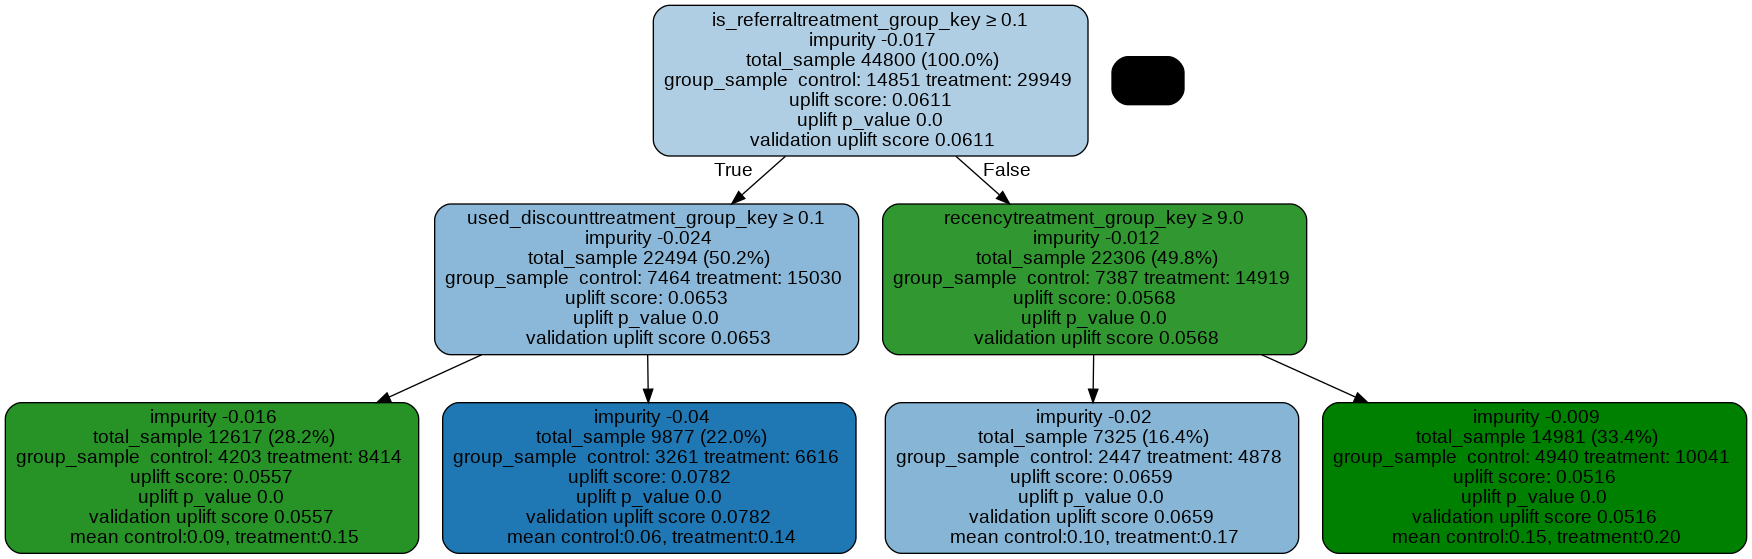

In [ ]:
uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=100, min_samples_treatment=30,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 t_train.map({1: 'treatment', 0: 'control'}).values,
                 y_train.values)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, X.columns)
Image(graph.create_png())


1. Признак `is_referal` больше, либо равен 0,1: (2) / (3) 
2. Признак `used_discount` больше, либо равен 0,1: <br>
    (+) показатель воздействия рекламной кампании на покупательскую активность (uplift score) = 0.0557<br>
    (-) показатель воздействия рекламной кампании на покупательскую активность (uplift score) = 0.0782
3. Признак `recency` больше, либо равен 9: <br>
    (+) показатель воздействия рекламной кампании на покупательскую активность (uplift score) = 0.0659<br>
    (-) показатель воздействия рекламной кампании на покупательскую активность (uplift score) = 0.0516

In [ ]:
uplift_tree_string(uplift_model.fitted_uplift_tree, X.columns)

is_referraltreatment_group_key >= 0.1?
yes -> used_discounttreatment_group_key >= 0.1?
		yes -> [0.09112538662859862, 0.1465414784882339]
		no  -> [0.05979760809567617, 0.13845223700120918]
no  -> recencytreatment_group_key >= 9.0?
		yes -> [0.09889660809154066, 0.16564165641656417]
		no  -> [0.15303643724696356, 0.20436211532715864]


# для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift

In [ ]:
# preprocess
catb_pipeline.fit(X_whole, y_whole)
X = catb_pipeline.transform(X_whole)

# train/valid split
X_train_index, X_valid_index, y_train_index, y_valid_index = train_test_split(X.index, y_whole.index, test_size=0.3, random_state=227)
X_train, y_train, t_train = X.loc[X_train_index], y_whole[y_train_index], t_whole[y_train_index]
X_valid, y_valid, t_valid = X.loc[X_valid_index], y_whole[y_valid_index], t_whole[y_valid_index]

# fit model
model = SoloModel(CatBoostClassifier(silent=True, thread_count=-1, random_state=31))
model.fit(X_train, y_train, t_train, estimator_fit_params={'cat_features': ['zip_code', 'channel']})
pred_valid = model.predict(X_valid)

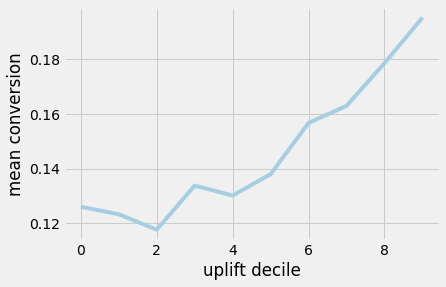

In [ ]:
# sort conversion by uplift predicts
sorted_index = pred_valid.argsort()[::-1]
sorted_data = pd.DataFrame(y_valid.iloc[sorted_index])

# get deciles
sorted_data['decile'] = pd.qcut(pred_valid[sorted_index], q=10, labels=[i for i in range(10)])

# group by deciles and cals mean conversion per group
mean_conv = sorted_data.groupby('decile').agg('mean')

plt.xlabel('uplift decile')
plt.ylabel('mean conversion')
plt.plot(mean_conv.values);

# построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [ ]:
forest_pipeline = Pipeline([#('preprocess', Preprocess()),
                            ('dummies', SetDummies(on=['zip_code', 'channel']))
                            ])

# preprocess
forest_pipeline.fit(X_whole, y_whole)
X = forest_pipeline.transform(X_whole)

# train/valid split
X_train_index, X_valid_index, y_train_index, y_valid_index = train_test_split(X.index, y_whole.index, test_size=0.3, random_state=227)
X_train, y_train, t_train = X.loc[X_train_index], y_whole[y_train_index], t_whole[y_train_index]
X_valid, y_valid, t_valid = X.loc[X_valid_index], y_whole[y_valid_index], t_whole[y_valid_index]

In [ ]:
uplift_model = UpliftRandomForestClassifier(max_depth=3, min_samples_leaf=100, min_samples_treatment=30,
                                            n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 t_train.map({1: 'treatment', 0: 'control'}).values,
                 y_train.values)

Текстовое описание решающего леса состоит из
1. Описания каждого дерева в отдельности
2. Усреднения результата по всем деревьям

Описание каждого дерева реализовано выше.

In [ ]:
tree_index = 2
uplift_tree_string(uplift_model.uplift_forest[tree_index].fitted_uplift_tree, X.columns)

is_referraltreatment_group_key >= 0.1?
yes -> recencytreatment_group_key >= 5.0?
		yes -> [0.0469208211143695, 0.11594026951560034]
		no  -> [0.11321321321321322, 0.187333530630364]
no  -> recencytreatment_group_key >= 6.0?
		yes -> [0.10404774260508562, 0.16977355185787565]
		no  -> [0.1652249134948097, 0.22057159026598755]


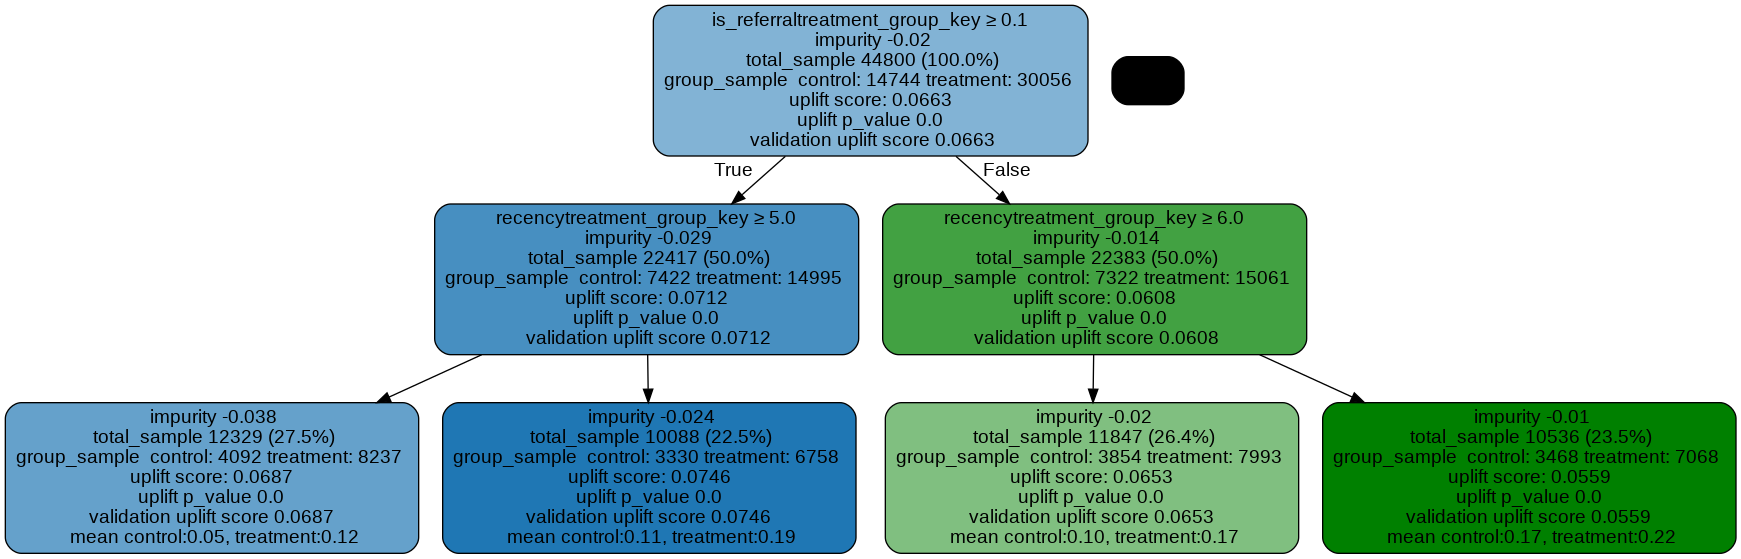

In [ ]:
graph = uplift_tree_plot(uplift_model.uplift_forest[tree_index].fitted_uplift_tree, X.columns)
Image(graph.create_png())